In [1]:
# import das bibliotecas
import psycopg2

import flask
from flask import Flask
from flask import request, jsonify, send_file, abort

import numpy as np
import pandas as pd
import pandas.io.sql as sqlio

import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.objects.conversion.dfg import converter as dfg_mining
from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.algo.filtering.log.variants import variants_filter

In [2]:
db_host = "postgres"
db_port = "5432"
db_name = "dbinovacnj"
db_user = "inovacnj"
db_pass = "inovacnj@admin"

In [3]:
def gerar_modelo_pm_from_params(codtribunal, grau, codorgaoj, natureza, codclasse, dtinicio, dtfim, sensibilidade, tipometrica = 'FREQUENCY', imageformat = 'png'):
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    
    qry = "SELECT npu, fase || ' : ' || descmovimento as atividade, mov_dtmov "
    qry+= "FROM inovacnj.fat_movimentos_te "
    qry+= "WHERE (1=1) "
    if codtribunal != None :
        qry+= "AND codtribunal = '" + codtribunal + "' "
    if codorgaoj != None :
        qry+= "AND oj_cod = '" + codorgaoj + "' "
    if grau != None :
        qry+= "AND grau = '" + grau + "' "
    if natureza != None :
        qry+= "AND natureza = '" + natureza + "' "
    if codclasse != None :
        qry+= "AND codclasse = " + str(codclasse) + " "
        
    if dtinicio != None and dtfim != None:
        qry+= "AND mov_dtmov BETWEEN to_timestamp('" + dtinicio + "', 'yyyy-MM-dd') AND to_timestamp('" + dtfim + "', 'yyyy-MM-dd') "
        
    qry+= "ORDER BY mov_dtmov ASC "
    
    df_logeventos_pd = sqlio.read_sql_query(qry, conn)
      
    #df_logeventos_pd.to_csv('./output/log_eventos_2.csv', mode='a', header=True, sep = ";", index=False, chunksize=1000)
    
    gviz = None
    
    if df_logeventos_pd.size > 0 :
    
        dataframe = pm4py.format_dataframe(df_logeventos_pd, case_id='npu', activity_key='atividade', timestamp_key='mov_dtmov')
        eventLog = pm4py.convert_to_event_log(dataframe)
        if sensibilidade != None :
            eventLog = variants_filter.filter_log_variants_percentage(eventLog, percentage=float(sensibilidade) / 100)

        #Create graph from log
        dfg = dfg_discovery.apply(eventLog)
        
        if tipometrica == 'PERFORMANCE' :
            parameters = {dfg_visualization.Variants.PERFORMANCE.value.Parameters.FORMAT: imageformat}
            # Visualise
            gviz = dfg_visualization.apply(dfg, log=eventLog, variant=dfg_visualization.Variants.PERFORMANCE, parameters=parameters)
        else :
            parameters = {dfg_visualization.Variants.FREQUENCY.value.Parameters.FORMAT: imageformat}
            # Visualise
            gviz = dfg_visualization.apply(dfg, log=eventLog, variant=dfg_visualization.Variants.FREQUENCY, parameters=parameters)
    
    return gviz

In [4]:
pip install svgutils

Note: you may need to restart the kernel to use updated packages.


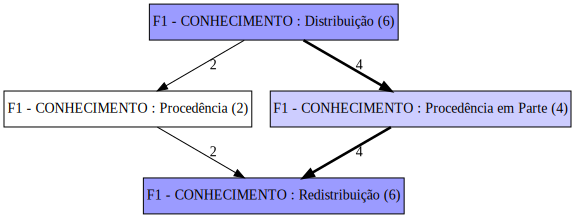

In [5]:
import svgutils.transform as sg
from IPython.display import SVG,display

gviz = gerar_modelo_pm_from_params('TJPE', None, '7628', 'CIVEL', 7, None, None, 0.4, tipometrica = 'FREQUENCY', imageformat = 'svg')
if gviz != None:
    #dfg_visualization.view(gviz)
    dfg_visualization.save(gviz, 'dfg.svg')
    
    display(SVG(filename='dfg.svg'))

else:
    print("sem dados")

In [6]:
import random
import string

def get_random_string(length):
    # Random string with the combination of lower and upper case
    letters = string.ascii_letters
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str

In [ ]:
app = Flask(__name__)

@app.route('/api/v1/tipo-justica')
def api_lista_tipojustica():
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
    
    qry = "SELECT DISTINCT tipo as cod, tipo as descricao "
    qry+= "FROM inovacnj.tribunal"
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)

@app.route('/api/v1/porte')
def api_lista_porte():
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
    
    qry = "SELECT DISTINCT porte as cod, porte as descricao "
    qry+= "FROM inovacnj.tribunal"
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)

@app.route('/api/v1/tribunal')
def api_lista_tribunal():
    porte = request.args.get('porte')
    tipo = request.args.get('tipo')
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
    
    qry = "SELECT cod, descricao, sigla, tipo, porte "
    qry+= "FROM inovacnj.tribunal "
    qry+= "WHERE (1=1) "
    if porte != None :
        qry+= "AND porte = '" + porte + "' "
    if tipo != None :
        qry+= "AND tipo = '" + tipo + "' "
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)

@app.route('/api/v1/orgao-julgador')
def api_lista_orgao_julgador():
    codtribunal = request.args.get('codtribunal')
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
    
    qry = "SELECT DISTINCT oj_cod, oj_instancia, oj_descricao, codtribunal "
    qry+= "FROM inovacnj.fat_movimentos_te "
    qry+= "WHERE (1=1) "
    if codtribunal != None :
        qry+= "AND codtribunal = '" + codtribunal + "' "
    qry+= "ORDER BY codtribunal, oj_descricao "
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)

@app.route('/api/v1/natureza')
def api_lista_natureza():
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
    
    qry = "SELECT distinct natureza as codnatureza, natureza as descricao "
    qry+= "FROM inovacnj.movimentocnj "
    qry+= "WHERE natureza IS NOT NULL "
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)

@app.route('/api/v1/classe')
def api_lista_classe():
    natureza = request.args.get('natureza')
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
    
    qry = "SELECT cod, descricao, sigla, codpai "
    qry+= "FROM inovacnj.classe "
    qry+= "WHERE (1=1)"
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)

@app.route('/api/v1/movimento')
def api_lista_movimento():
    natureza = request.args.get('natureza')
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
      
    qry = "SELECT cod, descricao, natureza, fase, codpai "
    qry+= "FROM inovacnj.movimentocnj "
    qry+= "WHERE (1=1)"
    if natureza != None :
        qry+= "AND natureza = '" + natureza + "' "
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)

@app.route('/api/v1/assuntos-ranking')
def api_lista_assuntos_ranking():
    tipo = request.args.get('tipo')
    codtribunal = request.args.get('codtribunal')
    codorgaoj = request.args.get('codorgaoj')
    natureza = request.args.get('natureza')
    codclasse = request.args.get('codclasse')
    
    conn = psycopg2.connect(host=db_host, port=db_port, database=db_name, user=db_user, password=db_pass)
    cur = conn.cursor()
      
    qry = "SELECT descassunto as assunto, count(distinct npu) as quantidade "
    qry+= "FROM inovacnj.fat_movimentos_te, inovacnj.tribunal "
    qry+= "WHERE (1=1) "
    qry+= "AND fat_movimentos_te.codtribunal = tribunal.cod "
    if tipo != None :
        qry+= "AND tribunal.tipo = '" + tipo + "' "
    if codtribunal != None :
        qry+= "AND tribunal.cod = '" + codtribunal + "' "
    if codorgaoj != None :
        qry+= "AND fat_movimentos_te.oj_cod = '" + codorgaoj + "' "
    if natureza != None :
        qry+= "AND fat_movimentos_te.natureza = '" + natureza + "' "
    if codclasse != None :
        qry+= "AND fat_movimentos_te.codclasse = '" + codclasse + "' "
        
    qry+= "GROUP BY descassunto "
    qry+= "ORDER BY quantidade desc "
    
    cur.execute(qry)
    lista = cur.fetchall()

    return jsonify(lista)


@app.route('/api/v1/gerar-modelo-pm')
def api_gerar_modelo_pm():
    codtribunal = request.args.get('codtribunal')
    grau = request.args.get('grau')
    codorgaoj = request.args.get('codorgaoj')
    natureza = request.args.get('natureza')
    codclasse = request.args.get('codclasse')
    dtinicio = request.args.get('dtinicio')
    dtfim = request.args.get('dtfim')
    sensibilidade = request.args.get('sensibilidade')
    metrica = request.args.get('metrica')
    formato = request.args.get('formato')
    
    
    if codtribunal is None:
        abort(400, description="codtribunal nao informado")
    if natureza is None:
        abort(400, description="natureza nao informado")
    
    gviz = gerar_modelo_pm_from_params(codtribunal, grau, codorgaoj, natureza, codclasse, \
               dtinicio, dtfim, sensibilidade, tipometrica=metrica, imageformat=formato)
    if gviz != None:
        #dfg_visualization.view(gviz)
        path = "./output/modelo_pm_" + get_random_string(8) + "." + str(formato).lower()
        dfg_visualization.save(gviz, path)
        return send_file(path, as_attachment=False)
    else:
        print("sem dados")
        abort(404, description="Nao encontrado")
    

app.run(host='0.0.0.0', port='8080')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://0.0.0.0:8080/ (Press CTRL+C to quit)
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 12:46:05] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 12:46:05] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 12:46:05] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 12:46:05] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 12:46:05] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 12:46:05] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 12:46:06] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 12:46:13] "GET /api/v1/tribunal?tipo=Estadual HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 12:46:19] "GET /api/v1/orgao-julgador?codtribunal=TJPE HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 12:46:58] "GET /api/v1

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 12:48:08] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=CIVEL&codclasse=7&sensibilidade=31&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 12:48:08] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=CIVEL&codclasse=7&sensibilidade=31&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 12:48:08] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=CIVEL&codclasse=7&sensibilidade=31&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 12:48:08] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=CIVEL&codclasse=7&sensibilidade=31&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 12:48:08] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=CIVEL&codclasse=7&sensibilidade=31&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 12:48:08] "GE

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 12:58:59] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=CIVEL&codclasse=7&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 12:58:59] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=CIVEL&codclasse=7&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 12:58:59] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=CIVEL&codclasse=7&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 12:58:59] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=CIVEL&codclasse=7&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 12:58:59] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=CIVEL&codclasse=7&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 12:58:59] "GE

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:16:19] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:16:20] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:16:20] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:16:20] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:16:21] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:16:21] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=CIVEL&s

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:32:29] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:32:29] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:32:29] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:32:29] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:32:29] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:32:29] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:32:47] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:32:47] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:32:47] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:32:47] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:32:47] "GET /api/v1/movimento HTTP/1

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:42:59] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:42:59] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:43:00] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:43:00] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:43:05] "GET /api/v1/tribunal?tipo=Estadual HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:43:10] "GET /api/v1/orgao-julgador?codtribunal=TJPE HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:46:49] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:46:49] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:46:49] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:46:49] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:59:19] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJAC&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:59:19] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJAC&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:59:19] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJAC&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:59:19] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJAC&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:59:19] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJAC&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 13:59:19] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJAC&natureza=CIVEL&s

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 14:46:42] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 14:46:42] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 14:46:43] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 14:47:26] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 14:47:26] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 14:47:26] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 14:47:26] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 14:47:26] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 14:47:26] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 14:47:27] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 14:47:51] "GET /api/v1/tri

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:03:00] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:03:01] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:03:52] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:03:52] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:03:52] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:03:52] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:03:52] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:03:52] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:03:53] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:03:59] "GET /api/v1/orgao-julgador?codtribunal=TJAL HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:0

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:05:20] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJAM&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:05:20] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJAM&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:05:21] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJAM&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:05:21] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJAM&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:05:21] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJAM&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:05:21] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJAM&natureza=CIVEL&s

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:12:43] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJBA&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:12:43] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJBA&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:12:43] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJBA&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:12:44] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJBA&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:12:44] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJBA&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:12:44] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJBA&natureza=CIVEL&s

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:28:40] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:28:40] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:28:40] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:28:41] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:29:09] "GET /api/v1/orgao-julgador?codtribunal=TJPE HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:32:24] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:32:24] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:32:24] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:32:24] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:32:24] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 15:32:24] "GET /api

sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:19] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:19] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:19] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:19] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:19] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:19] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&s

sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:20] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:20] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:20] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:20] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -


sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:21] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:21] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -


sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:22] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:22] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:22] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -


sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:23] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -


sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:23] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:24] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:24] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:24] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -


sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:24] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:24] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:24] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:24] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:24] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:24] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&s

sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:24] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -


sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:24] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:24] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:24] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:24] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:25] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -


sem dados
sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:25] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:25] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:25] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:25] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:25] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:25] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&s

sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:31] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:31] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:31] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -


sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:32] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -


sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:34] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:34] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:34] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:34] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:34] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:34] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&s

sem dados
sem dados
sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:34] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:34] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:34] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:34] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:34] "GET /api/v1/orgao-julgador?codtribunal=TJPE HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:34] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -


sem dados
sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:34] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:34] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -


sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:35] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:35] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:35] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:35] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -


sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:35] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:35] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:35] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:35] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:35] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:36] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&s

sem dados
sem dados
sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:36] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:36] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:36] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:36] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:36] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:36] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&s

sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:36] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:36] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:36] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:36] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:36] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:36] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&s

sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:36] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:36] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -


sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:36] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:36] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:36] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:36] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:36] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:36] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&s

sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:36] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:37] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:37] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -


sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:37] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:37] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:37] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -


sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:37] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:37] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -


sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:37] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:37] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:37] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:37] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:37] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:37] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&s

sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:37] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:37] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:37] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:37] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&s

sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&s

sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&s

sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&s

sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:38] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&s

sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:39] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:39] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:39] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:39] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:39] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:39] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&s

sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:39] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:39] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:39] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:39] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:39] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:39] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&s

sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:39] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:39] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:39] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:39] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:39] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:06:39] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&s

sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:09:21] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:09:21] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:09:21] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:09:21] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:09:21] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:09:21] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:09:22] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:12:35] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:12:35] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:12:35] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:12:35] "GET /api/v1/classe HTTP/1.

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:27:13] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:27:13] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:27:13] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:27:13] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:04] "GET /api/v1/orgao-julgador?codtribunal=TJES HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:08] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:08] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:08] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg

sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:08] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:08] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:08] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:08] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:08] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:08] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&s

sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:14] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -


sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:14] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:14] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:14] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:14] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -


sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:14] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:14] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:14] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:14] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:14] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:14] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJES&natureza=CIVEL&s

sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:19] "GET /api/v1/orgao-julgador?codtribunal=TJPE HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:55] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:55] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:55] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:55] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:55] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:55] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:28:56] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:29:10] "GET /api/v1/orgao-julgador?codtribunal=TJPE HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:50:25] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/

sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:54:29] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=JUIZADO&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:54:29] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=JUIZADO&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:54:29] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=JUIZADO&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:54:29] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=JUIZADO&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:54:29] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=JUIZADO&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:54:29] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&nature

sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:54:40] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=CRIMINAL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:54:40] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=CRIMINAL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:54:41] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=CRIMINAL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:54:41] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=CRIMINAL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:54:41] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&natureza=CRIMINAL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 17:54:41] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJPE&n

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:03:31] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:03:32] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:03:41] "GET /api/v1/orgao-julgador?codtribunal=TJPE HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:04:10] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:04:10] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:04:10] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:04:10] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:04:10] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:04:10] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:04:11] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:0

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:13:06] "GET /api/v1/orgao-julgador?codtribunal=TJCE HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:13:51] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:13:51] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:13:51] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:13:51] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:13:51] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:13:51] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:13:51] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:20:38] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:20:38] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:20:38] "GET /ap

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:46:34] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:46:34] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:46:35] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:46:44] "GET /api/v1/orgao-julgador?codtribunal=TJCE HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:49:01] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:49:01] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:49:01] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:49:01] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:49:01] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:49:01] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 18:49:02] "GET

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:03:29] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:03:36] "GET /api/v1/orgao-julgador?codtribunal=TJCE HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:08:10] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:08:10] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:08:10] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:08:10] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:08:10] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:08:11] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:08:11] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:08:23] "GET /api/v1/orgao-julgador?codtribunal=TJCE HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - 

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:21:57] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:21:58] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:21:58] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:21:58] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:21:58] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:22:08] "GET /api/v1/orgao-julgador?codtribunal=TJCE HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:22:56] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:22:56] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:22:56] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:22:56] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:22:56] "GET /api/

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:39:27] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:39:28] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:40:25] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:40:25] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:40:25] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:40:25] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:40:25] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:40:25] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:40:26] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:40:33] "GET /api/v1/orgao-julgador?codtribunal=TJCE HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:4

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:53:38] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:53:38] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:53:38] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:53:38] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:53:39] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:53:39] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:55:02] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:55:02] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:55:02] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:55:02] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 19:55:02] "GET /api/v1/movimento HTTP/1.1" 

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:11:00] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:13:08] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:13:08] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:13:09] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:13:09] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:13:09] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:13:09] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:13:09] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:13:16] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:13:16] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:13:16] "GET /api/v1/tribun

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:31:04] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:31:04] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:31:05] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:31:49] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:31:49] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:31:49] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:31:49] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:31:49] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:31:50] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:31:50] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:32:15] "GET /api/v1/tribun

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:39:35] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:39:35] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:39:35] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:39:35] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:39:35] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:39:35] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:39:36] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:39:49] "GET /api/v1/orgao-julgador?codtribunal=TJCE HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:40:01] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJCE&natureza=CIVEL&sensibilidade=61&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:40:09] "GET /api/v

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:46:52] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:46:52] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:46:52] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:47:47] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:47:47] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:47:47] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:47:47] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:47:47] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:47:47] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:47:48] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:47:56] "GET /api/v1/orga

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:57:05] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:57:05] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:57:06] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:57:26] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:57:26] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:57:26] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:57:26] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:57:26] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:57:26] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:57:27] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 20:58:20] "GET /api/v1/nat

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 21:10:06] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 21:10:07] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 21:10:07] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 21:10:07] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 21:10:07] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 21:10:07] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 21:10:07] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 21:10:30] "GET /api/v1/orgao-julgador?codtribunal=TJCE HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 21:16:11] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 21:16:11] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 21:16:11] "GET

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 21:31:38] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 21:31:38] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 21:31:38] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 21:31:38] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 21:31:38] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 21:31:49] "GET /api/v1/orgao-julgador?codtribunal=TJAP HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 21:31:53] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJAP&natureza=CIVEL&sensibilidade=60&metrica=FREQUENCY&formato=svg HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 21:37:27] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 21:37:27] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 21:37:27] "GET /api/v

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:01:39] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:01:39] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:01:40] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:01:40] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:01:48] "GET /api/v1/orgao-julgador?codtribunal=TJCE HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:02:51] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:02:51] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:02:51] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:02:51] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:02:51] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:02:51] "GET /a

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:09:06] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:09:14] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:09:14] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:09:14] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:09:14] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:09:14] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:09:14] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:09:15] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:09:18] "GET /api/v1/orgao-julgador?codtribunal=TJCE HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:10:41] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:10:

sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:19:01] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJCE&natureza=CRIMINAL&sensibilidade=20&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:19:01] "GET /api/v1/gerar-modelo-pm?&codtribunal=TJCE&natureza=CRIMINAL&sensibilidade=20&metrica=FREQUENCY&formato=svg HTTP/1.1" 404 -


sem dados
sem dados


INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:20:01] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:20:01] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:20:01] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:20:01] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:20:01] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:20:01] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:20:02] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:20:09] "GET /api/v1/orgao-julgador?codtribunal=TJCE HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:20:40] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:20:40] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:20:40] "GET

INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:26:27] "GET /api/v1/orgao-julgador?codtribunal=TJCE HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:26:59] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:26:59] "GET /api/v1/tribunal HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:26:59] "GET /api/v1/natureza HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:26:59] "GET /api/v1/movimento HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:26:59] "GET /api/v1/classe HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:27:00] "GET /api/v1/orgao-julgador HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:27:00] "GET /api/v1/assuntos-ranking HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:27:06] "GET /api/v1/orgao-julgador?codtribunal=TJCE HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/Nov/2020 22:27:58] "GET /api/v1/tipo-justica HTTP/1.1" 200 -
INFO:werkzeug:172.18.0.1 - - [06/